In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import t
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model

In [2]:
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]
ropa = ropa.astype({"Data": "datetime64[ns]"})
cena_ropy = ropa["Cena ropy [USD/Barrel]"]
straty = cena_ropy.diff()

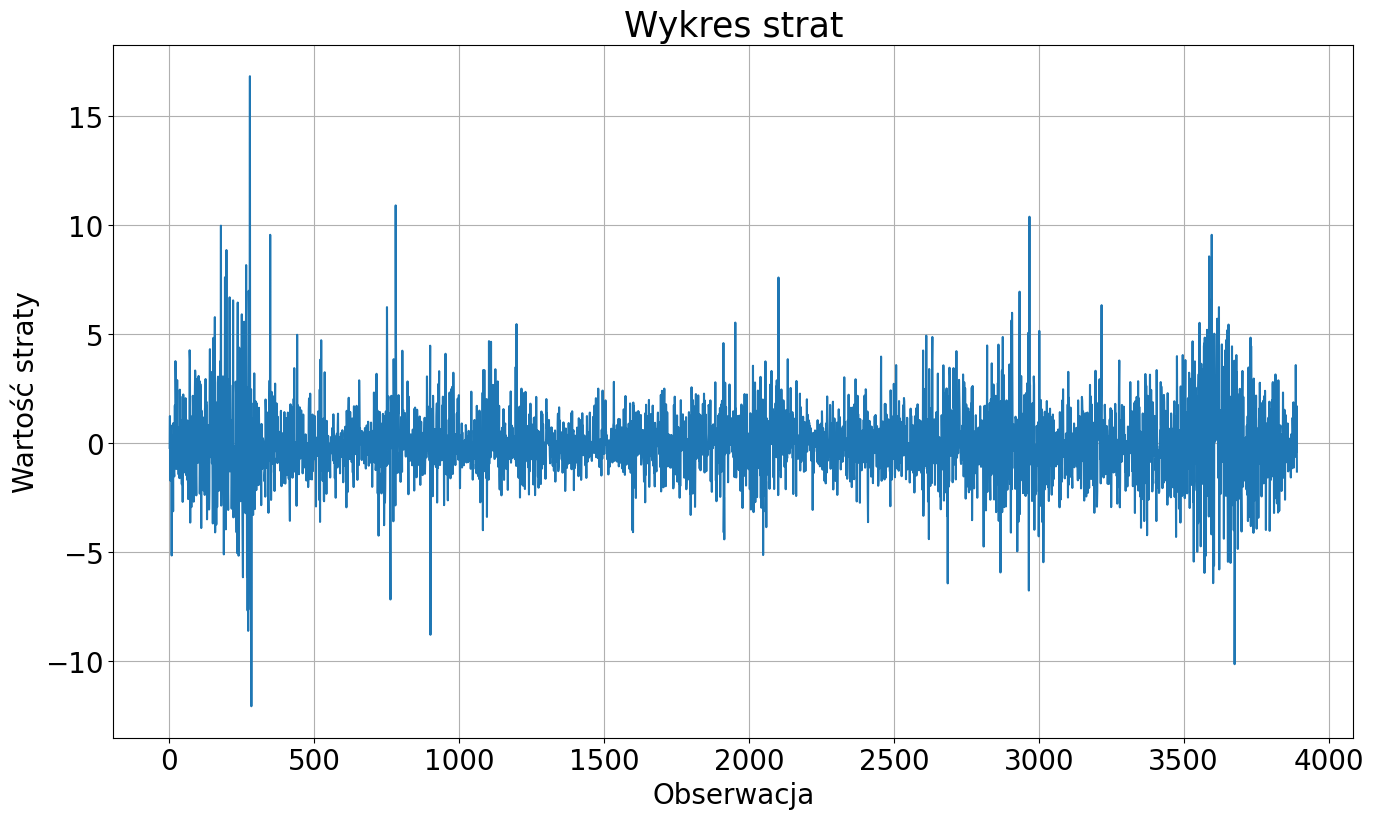

In [3]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Wykres strat', fontsize=25)
plt.xlabel('Obserwacja', fontsize=20)
plt.ylabel('Wartość straty', fontsize=20)
plt.fontsize=20
plt.plot(straty)
plt.grid()

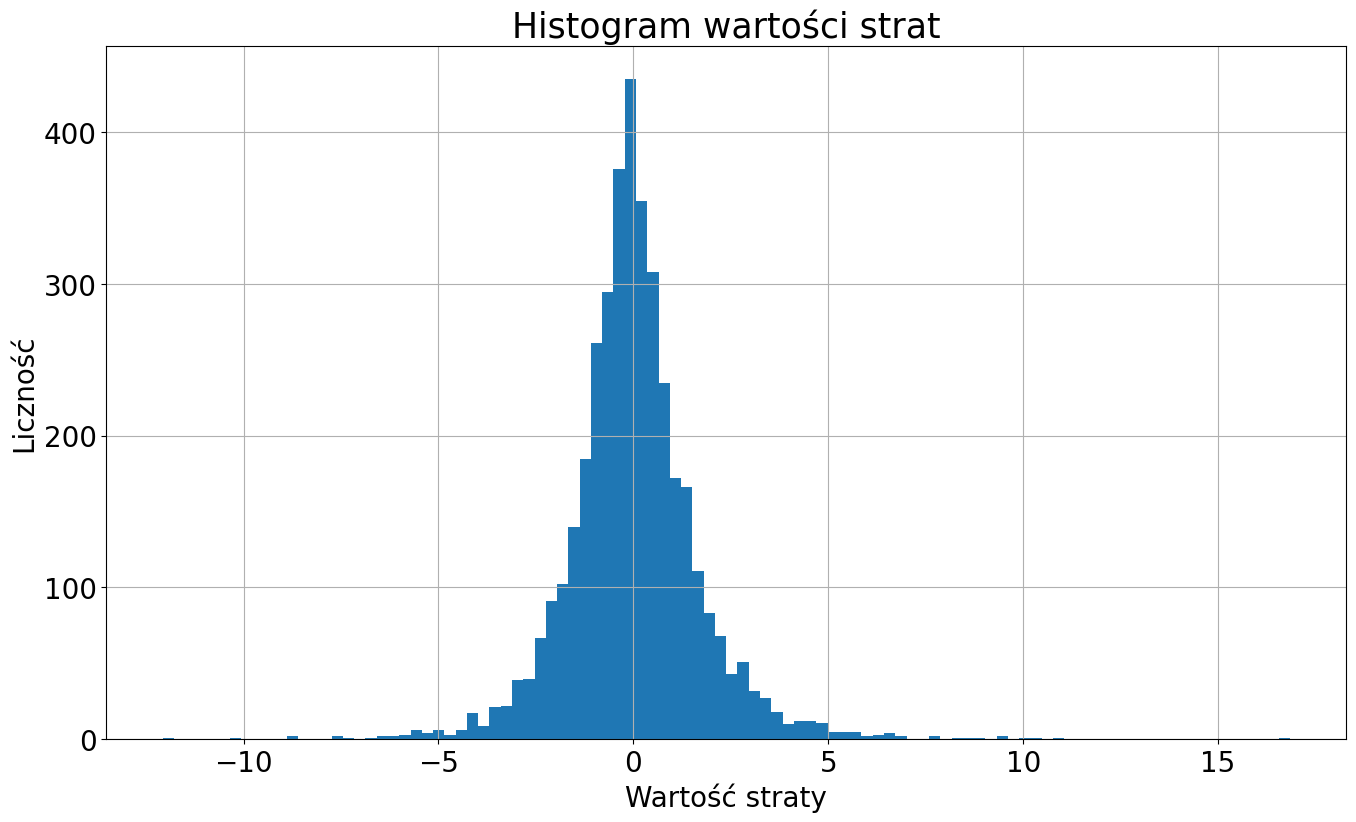

In [4]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Histogram wartości strat', fontsize=25)
plt.xlabel('Wartość straty', fontsize=20)
plt.ylabel('Liczność', fontsize=20)
plt.hist(straty, bins=100)
plt.grid()
plt.show()

# Z jakiego rozkładu są nasze straty?

## Rozkład normalny? Rozkład t-studenta? Rozkład Laplace'a? - nie pokrywają się

In [5]:
s = np.random.normal(np.mean(straty), np.std(straty), len(straty)*1000)
r = t.rvs(15, size=len(straty)*1000, loc=np.mean(straty), scale=np.std(straty))
l = np.random.laplace(np.mean(straty), np.std(straty), len(straty)*1000)

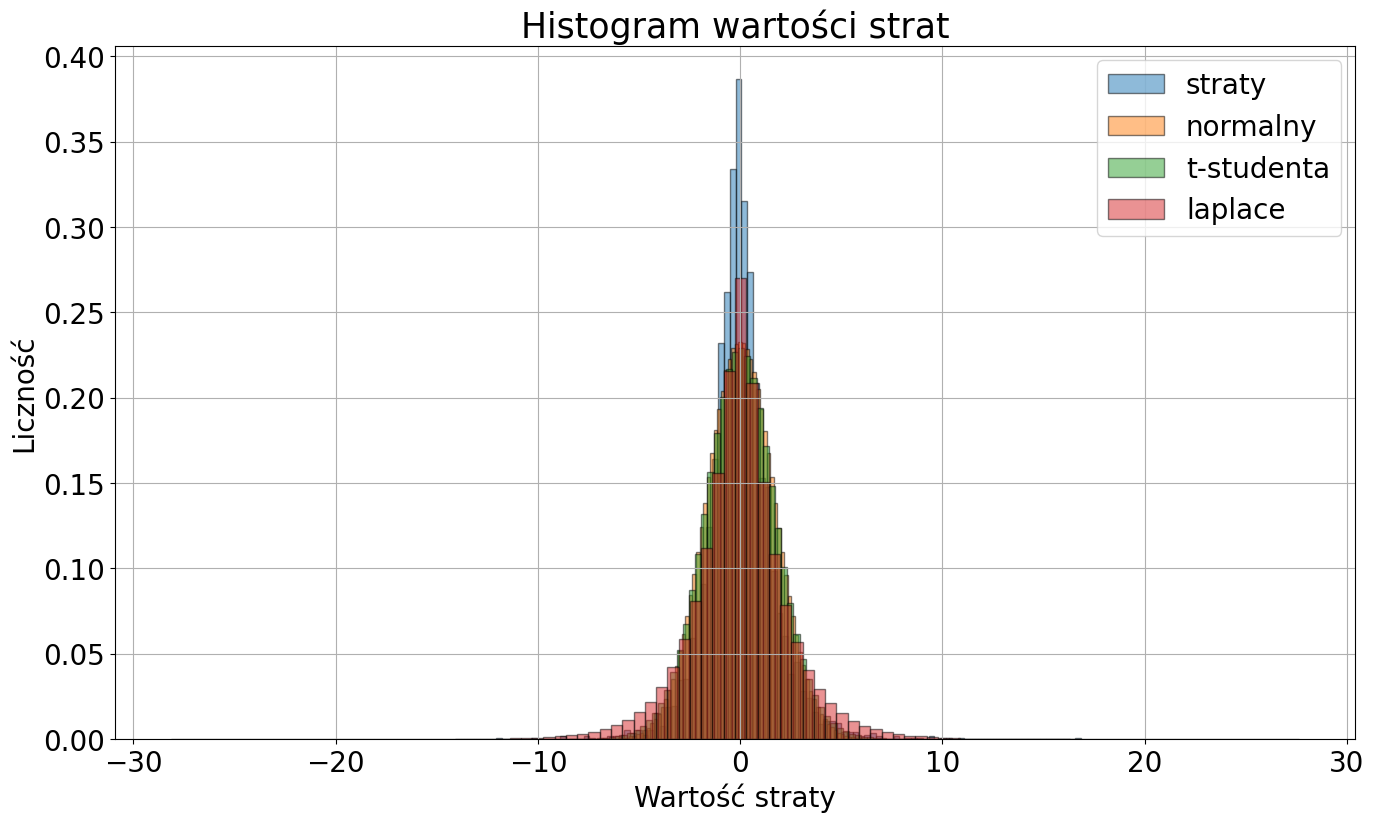

In [6]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Histogram wartości strat', fontsize=25)
plt.xlabel('Wartość straty', fontsize=20)
plt.ylabel('Liczność', fontsize=20)
plt.hist(straty, bins=100, alpha=0.5, edgecolor="black", density=True, label='straty')
plt.hist(s, bins=100, alpha=0.5, edgecolor="black", density=True, label='normalny')
plt.hist(r, bins=100, alpha=0.5, edgecolor="black", density=True, label='t-studenta')
plt.hist(l, bins=100, alpha=0.5, edgecolor="black", density=True, label='laplace')
plt.legend(prop={'size': 20}, loc='best')
plt.grid()
plt.show()

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

In [8]:
df, loc, sc = st.t.fit(straty[1:])
df, loc, sc

(3.181844111411766, -0.05484150246675541, 1.1089153269183432)

In [9]:
kstest(straty[1:], st.t(df, loc, sc).cdf)

KstestResult(statistic=0.014883494449071444, pvalue=0.3512921803158724, statistic_location=-0.5400000000000063, statistic_sign=-1)

In [10]:
x = np.linspace(min(straty[1:]), max(straty[1:]), num=1000)

In [11]:
t = st.t.pdf(x, df, loc, sc)

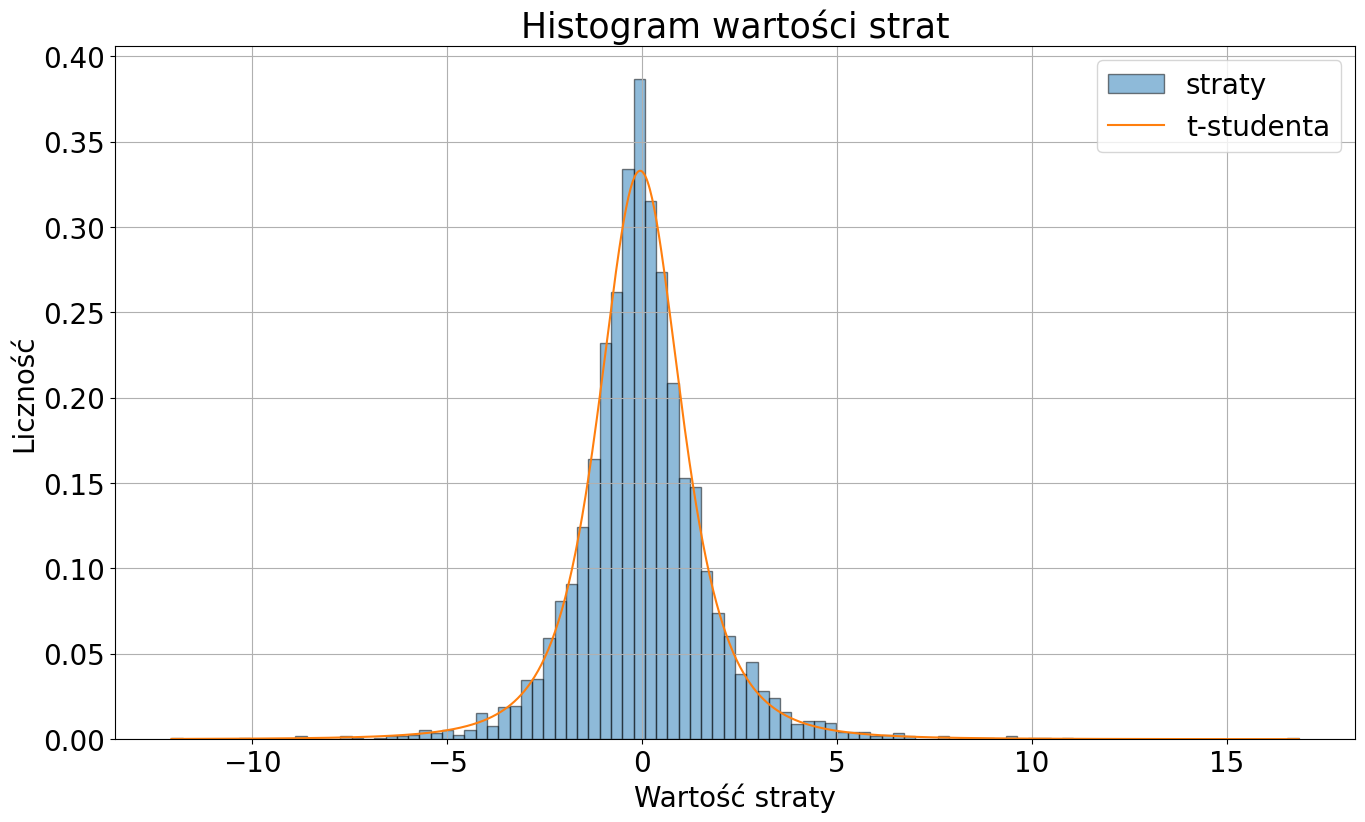

In [12]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Histogram wartości strat', fontsize=25)
plt.xlabel('Wartość straty', fontsize=20)
plt.ylabel('Liczność', fontsize=20)
plt.hist(straty[1:], bins=100, alpha=0.5, edgecolor="black", density=True, label='straty')
plt.plot(x, t, label='t-studenta')
plt.legend(prop={'size': 20}, loc='best')
plt.grid()
plt.show()

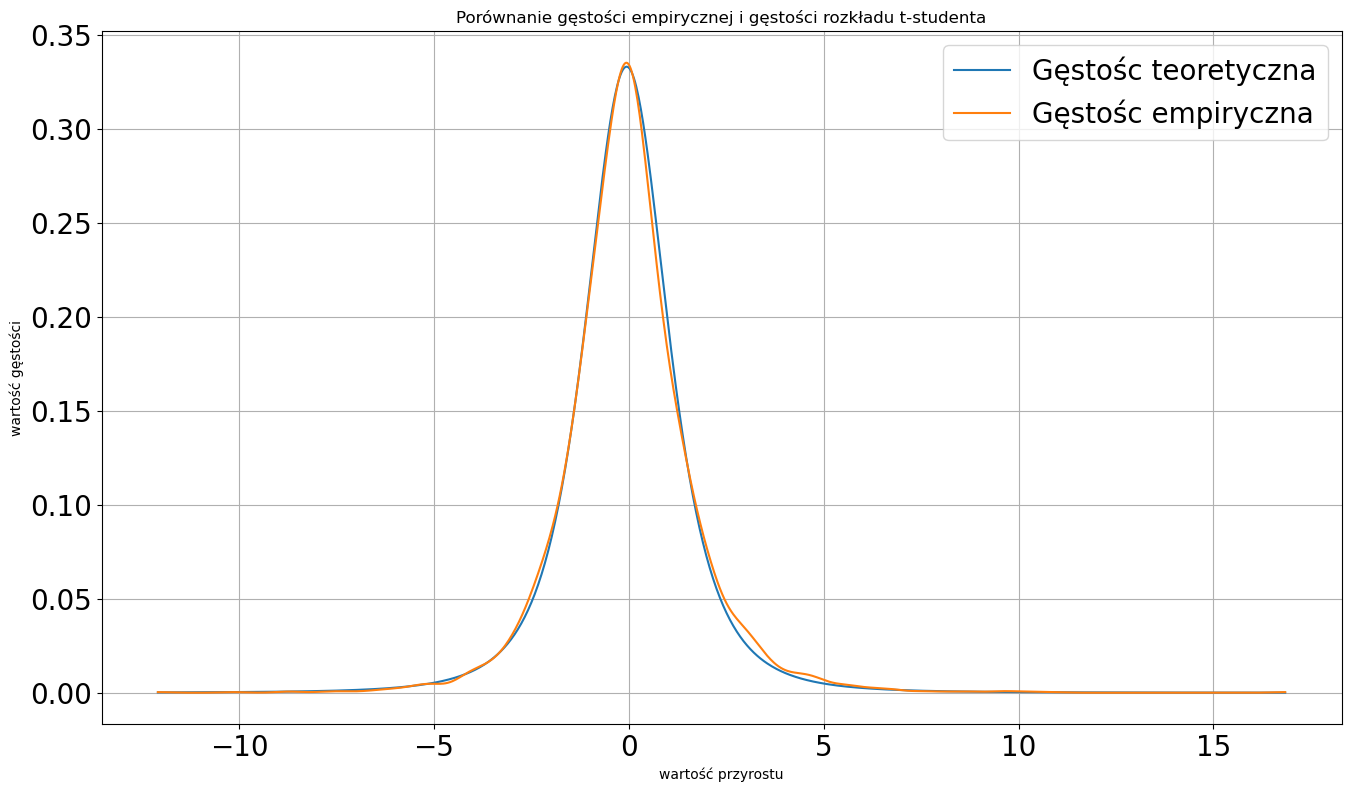

In [13]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x, st.t(df, loc, sc).pdf(x), label='Gęstośc teoretyczna')
plt.plot(x, st.gaussian_kde(straty[1:]).pdf(x), label='Gęstośc empiryczna')
plt.title('Porównanie gęstości empirycznej i gęstości rozkładu t-studenta')
plt.xlabel('wartość przyrostu')
plt.ylabel('wartość gęstości')
plt.legend(prop={'size': 20}, loc='best')
plt.grid()
plt.show()

# Plot

In [14]:
def plot(values, VaR95, VaR99, savefig_path):
    plt.figure(figsize=(16, 9))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    # Plotting values
    plt.title('Straty dla ropy', fontsize=20)
    plt.xlabel('Obserwacja', fontsize=20)
    plt.ylabel('Wartość straty', fontsize=20)
    plt.plot(values, 'o')
    
    # Plotting quantiles
    Q95, Q99 = values.quantile([.95, .99])
    plt.axhline(y=Q95 , color='k', linestyle='-', linewidth=3, label='Q_95 = ' + str(round(Q95, 4)))
    plt.axhline(y=Q99 , color='brown', linestyle='-', linewidth=3, label='Q_99 = ' + str(round(Q99, 4)))
    
    # Ploting VaRs
    plt.axhline(y=VaR95 , color='k', linestyle='--', linewidth=3, label='VaR_95 = ' + str(round(VaR95, 4)))
    plt.axhline(y=VaR99 , color='brown', linestyle='--', linewidth=3, label='VaR_99 = ' + str(round(VaR99, 4)))

    # 
    plt.legend(loc='best', prop={'size': 20})
    plt.grid()
    plt.savefig(savefig_path, transparent=True)

# Metoda parametryczna

In [15]:
#Var95
var_95_1 = st.t(df, loc, sc).ppf(0.95)
#Var99
var_99_1 = st.t(df, loc, sc).ppf(0.99)

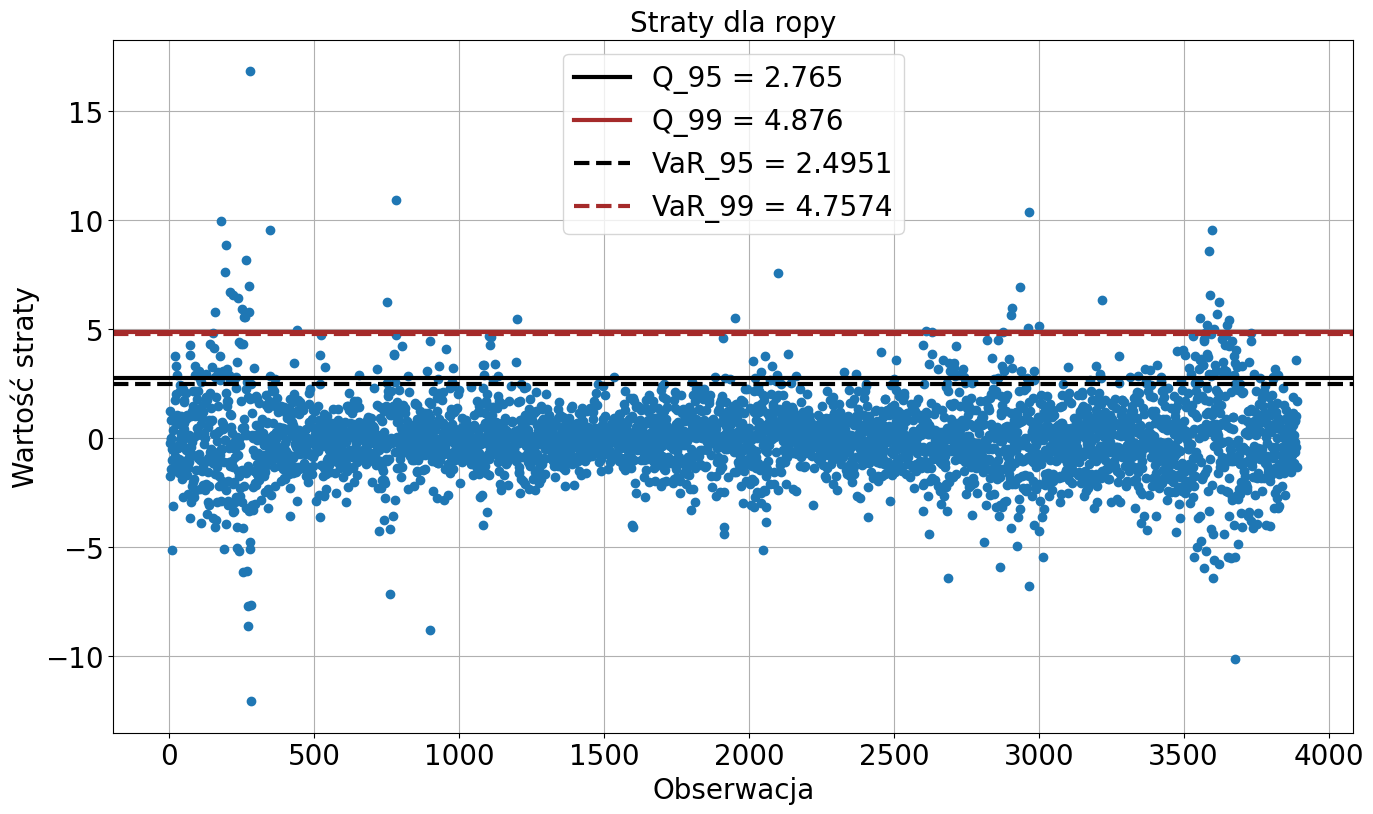

In [16]:
plot(straty, var_95_1, var_99_1, 'VaR_parametric')

# Metoda symulacji historycznej

Mając próbkę danych $(L_1, L_2, \ldots, L_t)$ obliczamy kwantyl empiryczny na poziomie $\alpha$ (ozn. $q_\alpha$), to
znaczy taki punkt, poniżej którego jest $(1 − \alpha)\%$ obserwacji z próbki. Wtedy:
$$VaR_\alpha = q_\alpha$$. 

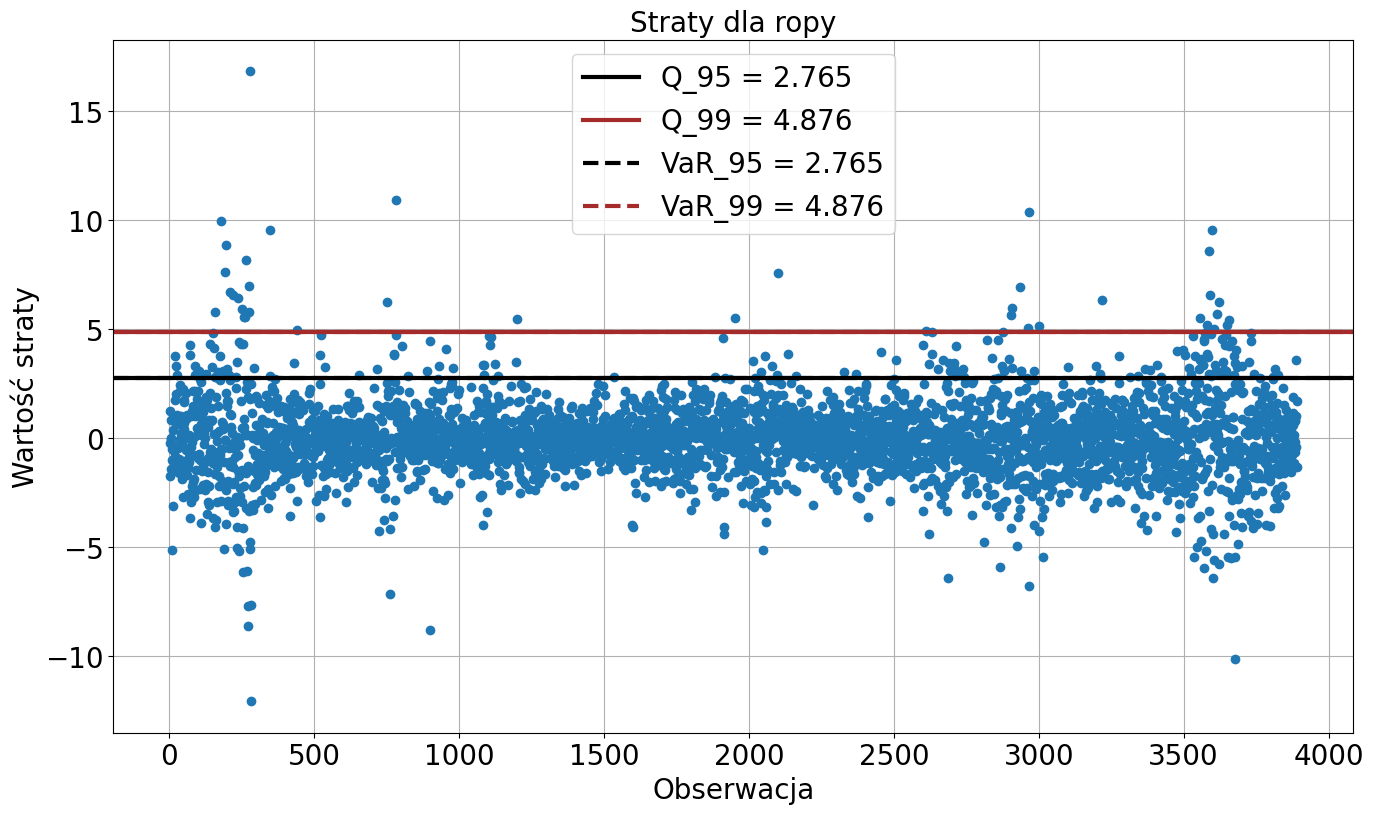

In [17]:
plot(straty, straty.quantile(.95), straty.quantile(.99), 'VaR_historic')

# Metoda ważonej symulacji historycznej

Przyjmijmy, że obserwacje najbliższe momentowi obliczeń powinny mieć największe znaczenie/wagi dla estymacji VaR. Można zastosować wagi wykładnicze, to znaczy dla próbki $t$ obserwacji:
<ul>
    <li> $w(1)$ − waga/prawdopodobieństwo obserwacji $t$,
    <li> $w(2) = \lambda w(1)$ − waga/prawdopodobieństwo obserwacji $t-1$,
    <li> $w(3) = \lambda^2 w(1) $− waga/prawdopodobieństwo obserwacji $t-2$,
    <li> $\vdots$
    <li> $w(t) = \lambda^{t−1}w(1)$ − waga/prawdopodobieństwo obserwacji 1,
</ul>

gdzie $\lambda \in (0, 1]$ jest ustalonym parametrem. Zwykle przyjmuje się $\lambda \in (0.95, 0.99]$. Z kolei $w(1)$
można wyznaczyć z warunku $w(1) = 1 - \sum_{i=2}^{t} w(i)$, podstawiając odpowiednie wartości $w(i)$ i przekształcając otrzymane równanie. Wyznaczenie w(1):


$$w(1) = 1 - \sum_{i=2}^{t} w(i)$$ <br>
$$w(1) = 1 - w(2) - w(3) - \ldots - w(t)$$ <br>
$$w(1) = 1 - \lambda w(1) - \lambda^2 w(1) - \ldots - \lambda^{t−1}w(1)$$ <br>
$$w(1) = 1 - w(1) \cdot (\lambda + \lambda^2 + \ldots + \lambda^{t−1})$$ <br>
$$w(1) + w(1) \cdot (\lambda + \lambda^2 + \ldots + \lambda^{t−1})= 1 $$ <br>
$$w(1) + w(1) \cdot (\lambda\frac{1-\lambda^{t-1}}{1-\lambda})= 1 $$ <br>
$$w(1) ( 1 + \lambda\frac{1-\lambda^{t-1}}{1-\lambda})= 1 $$ <br>
$$w(1) ( 1 + \frac{\lambda-\lambda^{t}}{1-\lambda})= 1 $$ <br>
$$w(1) ( \frac{1-\lambda+\lambda-\lambda^{t}}{1-\lambda})= 1 $$ <br>
$$w(1) ( \frac{1-\lambda^{t}}{1-\lambda})= 1 $$ <br>
$$w(1) = \frac{1-\lambda}{1-\lambda^{t}} $$ <br>


In [18]:
def weighted_historical_matrix(data, _lambda=0.97):
    w1 = (1-_lambda)/(1-_lambda**len(data))

    weights = np.cumprod(np.ones(len(data)-1)*_lambda)*w1
    weights = np.append(np.array([w1]), weights)
    weights = np.flip(weights)

    my_matrix = np.stack((list(data), list(weights)), axis=1)
    my_matrix = my_matrix[my_matrix[:,0].argsort()]

    my_matrix[:,1] = np.cumsum(my_matrix[:,1])
    
    return my_matrix

In [19]:
def find_weighted_historical_VaR(matrix, alpha):
    errors = abs(matrix[:,1]-(1-alpha)) # od kazdej wartosci odejmujemy 1 - alpha
    index = np.argmin(errors) # najmniejsza wartosc to ta, ktora jest najblizej 0, bo odjelismy 1-alphe
    VaR =  matrix[index,0]
    return VaR

In [20]:
matrix = weighted_historical_matrix(straty, _lambda=0.97)

VaR95 = find_weighted_historical_VaR(matrix, 0.05)
VaR99 = find_weighted_historical_VaR(matrix, 0.01)

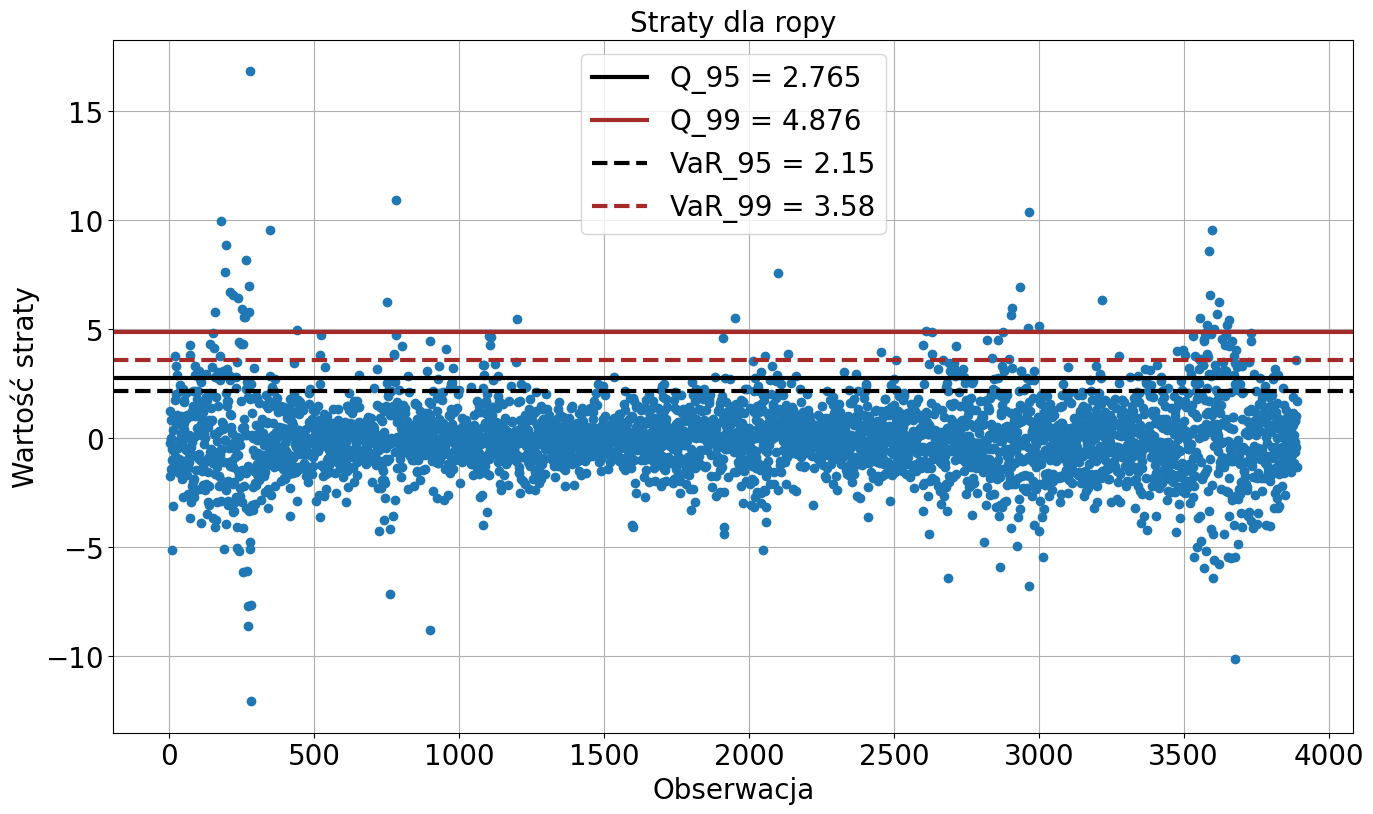

In [21]:
plot(straty, VaR95, VaR99, 'VaR_weighted_historic')

# Metoda filtrowania symulacji historycznej (GARCH)

In [22]:
def find_GARCH_VaR(data, my_alpha):
    model = arch_model(data, vol='Garch', p=1, q=1)
    result = model.fit(disp='off')

    # mu = mu
    # omega - sigma_0
    # alpha[1] - c
    # beta[1] - b
    
    mu, omega, alpha, beta = result.params.mu, result.params.omega, result.params['alpha[1]'], result.params['beta[1]']
    #Wyliczamy sigme
    sigma = [omega]
    for i in range(len(data)-1):
        s = omega + alpha*data[i+1]**2 + beta*sigma[i]
        sigma.append(s)

    #Obliczamy 'filtrowane' dane
    filtered_data = (data[:-1]-mu)/np.sqrt(sigma[:-1])

    #Obliczamy VaR
    last_sigma = sigma[-1]
    filtered_data_Q = filtered_data.quantile(1-my_alpha)
    
    VaR = filtered_data_Q*np.sqrt(last_sigma)+mu
    
    return VaR

In [23]:
VaR95 = find_GARCH_VaR(straty[1:], 0.05)
VaR99 = find_GARCH_VaR(straty[1:], 0.01)

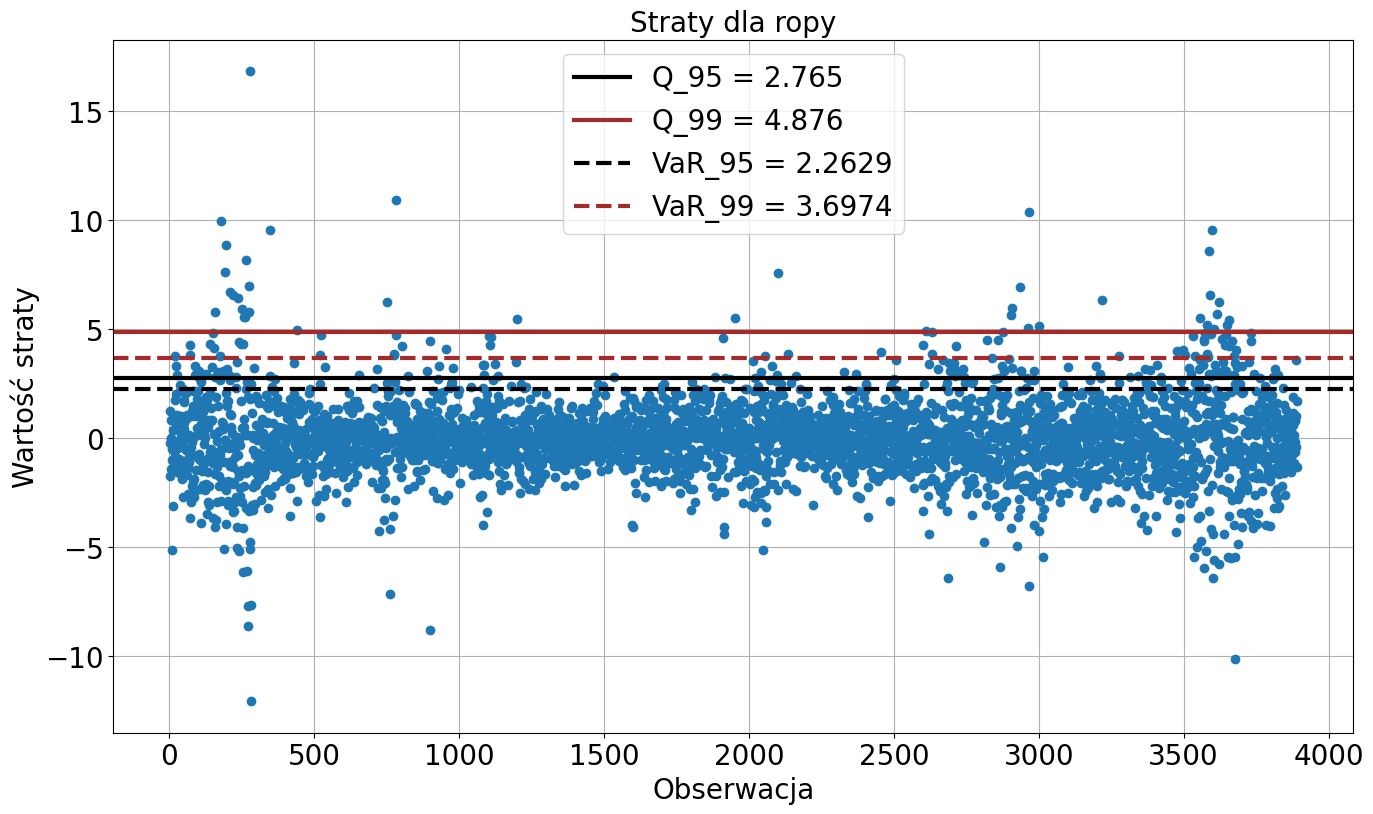

In [24]:
plot(straty, VaR95, VaR99, 'VaR_GARCH')

# Metoda Monte Carlo 
przy założeniu, że nasze straty są z rozkładu normalnego z parametrami: średnia ze straty i odchylenie. Tutaj warto sprawdzić, który rozkład najlepiej opisuje nasze dane i wygenerować 1kk obserwacji z tego rozkładu i wtedy wyliczyć kwantyle

In [25]:
s = np.random.normal(np.mean(straty), np.std(straty), int(1e6))
VaR95 = np.quantile(s, .95)
VaR99 = np.quantile(s, .99)

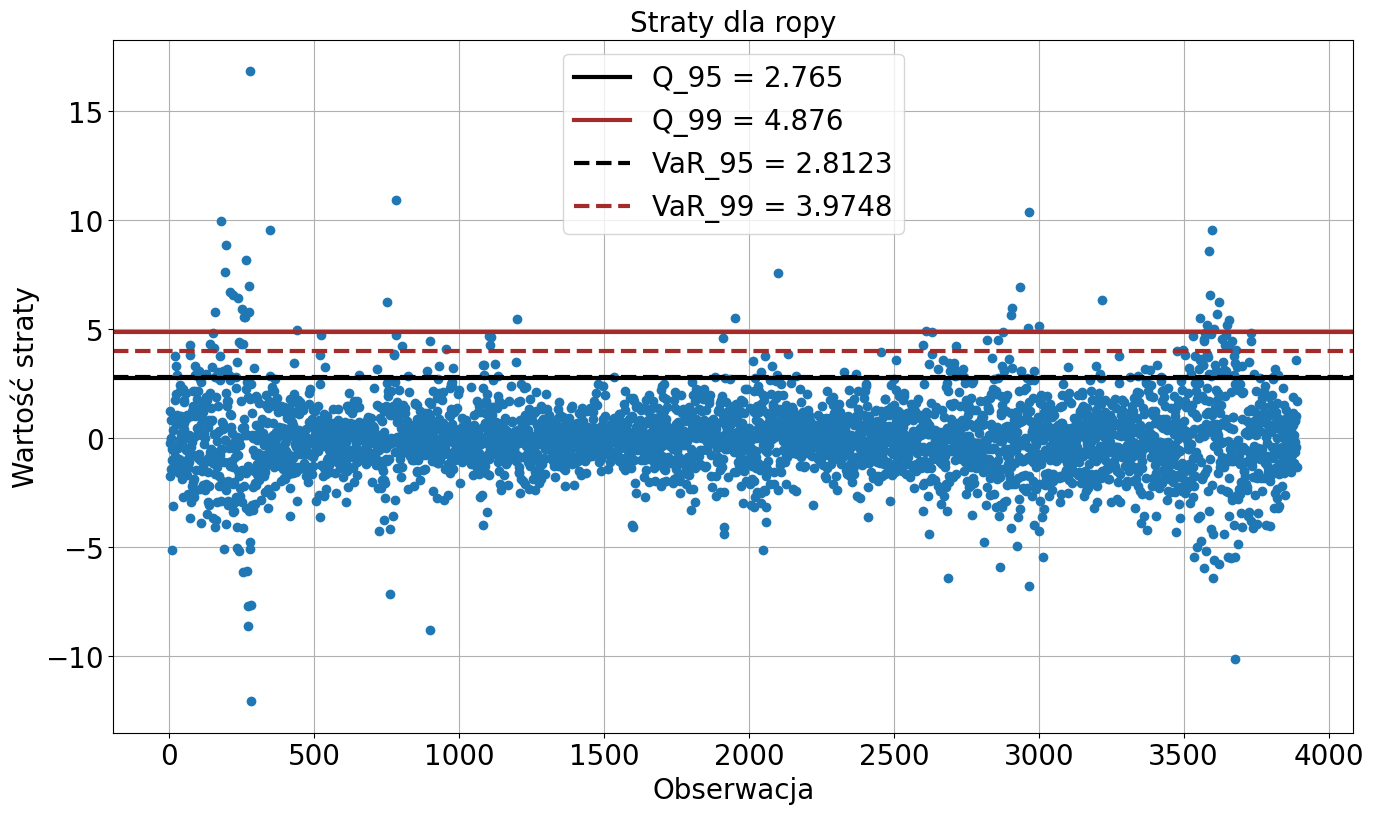

In [26]:
plot(straty, VaR95, VaR99, 'VaR_MonteCarlo.png')

# Metoda Monte Carlo - geometryczny ruch Browna

In [27]:
def monte_carlo(first, last, cena_ropy, n_simulations):
    r_t = (cena_ropy/cena_ropy.shift(1) - 1)[1:]
    train = list(cena_ropy[first:last])
    # test = list(cena_ropy[last:])
    S_0 = train[-1]

    dt  = 1
    T = 1
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(r_t[first:last])
    sigma = np.std(r_t[first:last])
    W = [np.cumsum(np.random.normal(0, 1, int(N))) for i in range(0, n_simulations)]

    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = [sigma * W[i] for i in range(0, n_simulations)]

    S = np.array([S_0 * np.exp(drift + diffusion[i]) for i in range(0, n_simulations)])
    S = np.hstack((np.array([[S_0] for scen in range(n_simulations)]), S))
    vec = S[:, 1]-S[:, 0]
    return(vec)


In [28]:
vec_mc = monte_carlo(0, len(cena_ropy), cena_ropy, 1000000)

In [29]:
VaR95 = np.quantile(vec_mc, .95)
VaR99 = np.quantile(vec_mc, .99)
print("VaR 0.95:", VaR95, "\nVaR 0.99:", VaR99)

VaR 0.95: 3.1624396975113624 
VaR 0.99: 4.507411526814201


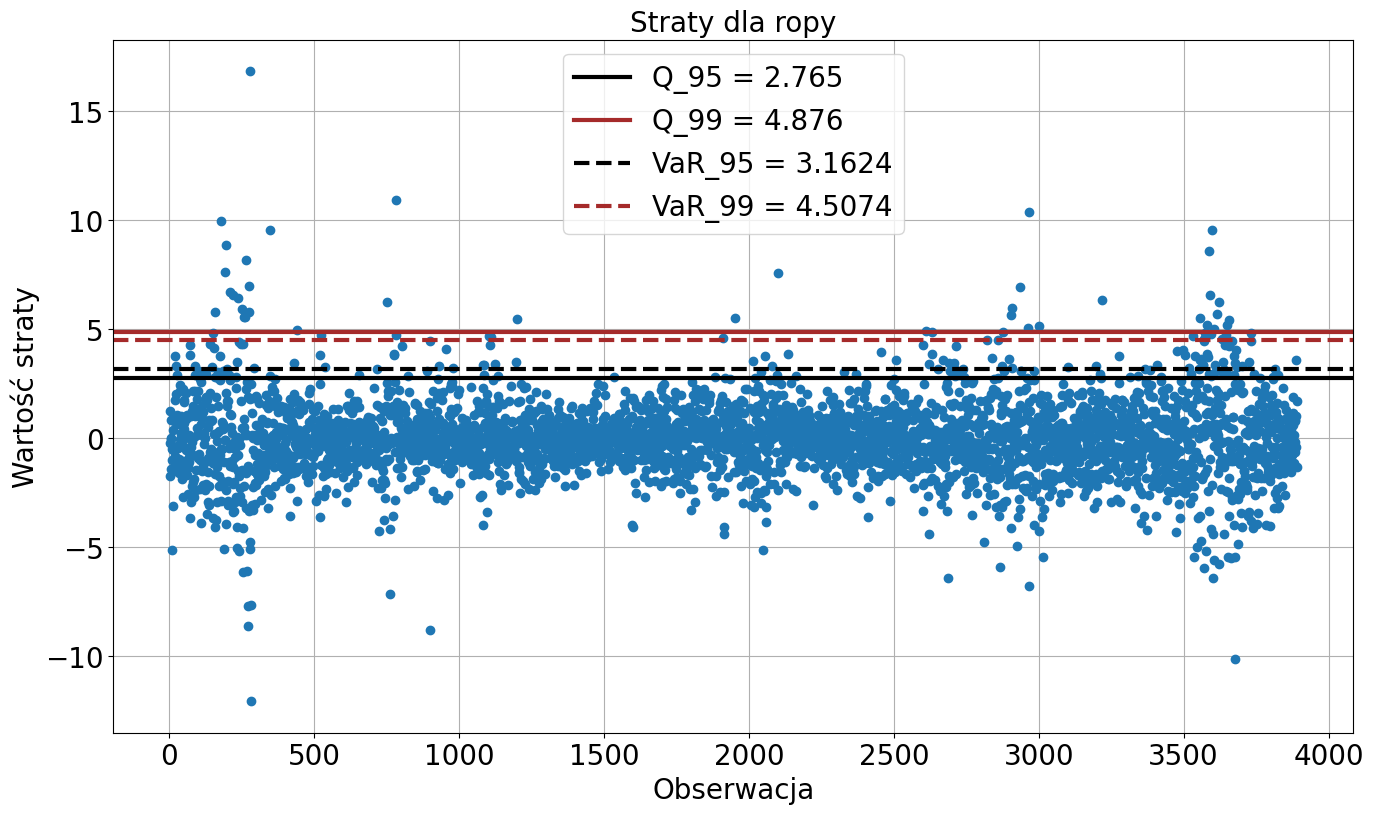

In [30]:
plot(straty, VaR95, VaR99, "path")

---------------------------------------------------------
# ZADANIE 2
---------------------------------------------------------

# Backtesting

In [31]:
def backtesting(alpha, data, method, *method_parameters):
    n = len(data)//2
    results = np.zeros(n)
    for i in range(n):
        VaR = method(data[i:n+i], alpha, *method_parameters)
        results[i] = int(data[n+i] < VaR)
    return results

## Test kupca

In [32]:
from collections import namedtuple
from scipy.stats import chi2

In [33]:
test_result = namedtuple("Result", "statistic p_value")

In [34]:
def kupiec_test(failures_vector, alpha):
    n = len(failures_vector)
    I1 = sum(failures_vector == 1)
    I0 = n - I1
    p_hat = I1 / n
    statistic = -2 * (I0 * (np.log((1 - alpha) / (1 - p_hat))) + I1 * np.log(alpha / p_hat))
    p_value = 1 - chi2.cdf(statistic, df=1)
    return test_result(statistic, p_value)

## Test niezależności

In [35]:
def independence_test(failures_vector):
    n = len(failures_vector)
    neighbours_counter = np.full([n, 4], 0)
    for i in range(1, n-1):
        neighbours_counter[i, 0] = (failures_vector[i-1] == 0) and (failures_vector[i] == 0)
        neighbours_counter[i, 1] = (failures_vector[i-1] == 0) and (failures_vector[i] == 1)
        neighbours_counter[i, 2] = (failures_vector[i-1] == 1) and (failures_vector[i] == 0)
        neighbours_counter[i, 3] = (failures_vector[i-1] == 1) and (failures_vector[i] == 1)
    I_00 = sum(neighbours_counter[:, 0])
    I_01 = sum(neighbours_counter[:, 1])
    I_10 = sum(neighbours_counter[:, 2])
    I_11 = sum(neighbours_counter[:, 3])
    p_00= I_00 / (I_00 + I_01)
    p_01= I_01 / (I_00 + I_01)
    p_10= I_10 / (I_10 + I_11)
    p_11= I_11 / (I_10 + I_11)
    hat_p = (I_01 + I_11) / (I_00 + I_01 + I_10 + I_11)
    al = np.log(1 - hat_p) * (I_00 + I_10) + np.log(hat_p) * (I_01 + I_11)
    bl = np.log(p_00) * I_00 + np.log(p_01) * I_01 + np.log(p_10) * I_10 + np.log(p_11) * I_11
    statistic = -2 * (al - bl)
    pvalue = 1 - chi2(df=1).cdf(statistic)
    return test_result(statistic, pvalue)

In [36]:
straty_backtesting = straty[-1800:].reset_index(drop=True)

# 1a)

In [38]:
def a_method(data, alpha, *args):
    return st.t(*st.t.fit(data)).ppf(alpha)

In [39]:
a_wektor_przekroczen_95 = backtesting(0.95, straty_backtesting, a_method)

In [40]:
a_wektor_przekroczen_99 = backtesting(0.99, straty_backtesting, a_method)

In [41]:
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(a_wektor_przekroczen_99))
print("0.95:", np.mean(a_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(a_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(a_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9844444444444445
0.95: 0.9222222222222223

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.015330614262761092
0.0475: 0.0718081819305401


# 1b)

In [42]:
def b1_method(data, alpha, *args):
    return np.quantile(data, alpha)
    
def b2_method(data, alpha, *args):
    _lambda = 0.97
    w1 = (1-_lambda)/(1-_lambda**len(data))

    weights = np.cumprod(np.ones(len(data)-1)*_lambda)*w1
    weights = np.append(np.array([w1]), weights)
    weights = np.flip(weights)

    my_matrix = np.stack((list(data), list(weights)), axis=1)
    my_matrix = my_matrix[my_matrix[:,0].argsort()]

    my_matrix[:,1] = np.cumsum(my_matrix[:,1])

    errors = abs(my_matrix[:,1]-(1-alpha)) # od kazdej wartosci odejmujemy 1 - alpha
    index = np.argmin(errors) # najmniejsza wartosc to ta, ktora jest najblizej 0, bo odjelismy 1-alphe
    VaR =  my_matrix[index,0]

    return VaR

def b3_method(data, alpha, *args):
    data_to_list = list(data)
    model = arch_model(data_to_list, vol='Garch', p=1, q=1)
    result = model.fit(disp='off')
    # mu = mu
    # omega - sigma_0
    # alpha[1] - c
    # beta[1] - b   
    mu, omega, c, b = result.params.mu, result.params.omega, result.params['alpha[1]'], result.params['beta[1]']
    sigma = [omega]
    for i in range(len(data_to_list)-1):
        s = omega + c*data_to_list[i+1]**2 + b*sigma[i]
        sigma.append(s)

    #Obliczamy 'filtrowane' dane
    filtered_data = (data[:-1]-mu)/np.sqrt(sigma[:-1])

    #Obliczamy VaR
    last_sigma = sigma[-1]
    filtered_data_Q = filtered_data.quantile(1-alpha)
    
    VaR = filtered_data_Q*np.sqrt(last_sigma)+mu
    
    return VaR

In [43]:
b1_wektor_przekroczen_95 = backtesting(0.95, straty_backtesting, b1_method)
b1_wektor_przekroczen_99 = backtesting(0.99, straty_backtesting, b1_method)

In [44]:
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b1_wektor_przekroczen_99))
print("0.95:", np.mean(b1_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b1_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b1_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9877777777777778
0.95: 0.9377777777777778

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.012086268693610182
0.0475: 0.05841552342108514


In [45]:
b2_wektor_przekroczen_95 = backtesting(0.05, straty_backtesting, b2_method)
b2_wektor_przekroczen_99 = backtesting(0.01, straty_backtesting, b2_method)

In [46]:
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b2_wektor_przekroczen_99))
print("0.95:", np.mean(b2_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b2_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b2_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9822222222222222
0.95: 0.94

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.017481151897169693
0.0475: 0.056462736373748615


In [47]:
b3_wektor_przekroczen_95 = backtesting(0.05, straty_backtesting, b3_method)
b3_wektor_przekroczen_99 = backtesting(0.01, straty_backtesting, b3_method)

In [48]:
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b3_wektor_przekroczen_99))
print("0.95:", np.mean(b3_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b3_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b3_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9877777777777778
0.95: 0.9455555555555556

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.012086268693610182
0.0475: 0.05153751081448524


# 1c)

In [49]:
# monte carlo, GBM

In [69]:
def backtesting_1c(alpha, cena_ropy, straty, n_simulations):
    straty.reset_index(drop=True)
    n = len(straty)//2
    results = np.zeros(n)
    for i in range(n):
        VaR = np.quantile(monte_carlo(i, n+i, cena_ropy, n_simulations), alpha)
        results[i] = int(straty[n+i] < VaR)
    return(results)

In [70]:
c_wektor_przekroczen_99 = backtesting_1c(0.99, cena_ropy[-1801:].reset_index(drop=True), straty_backtesting, 1000)

In [71]:
c_wektor_przekroczen_95 = backtesting_1c(0.95, cena_ropy[-1801:].reset_index(drop=True), straty_backtesting, 1000)

In [72]:
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(c_wektor_przekroczen_99))
print("0.95:", np.mean(c_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(c_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(c_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9555555555555556
0.95: 0.9155555555555556

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.0425163762204919
0.0475: 0.07739957978000246


# Porównanie wyników

## $VaR_{95}$

In [75]:
df_backtesting_95 = pd.DataFrame(columns=["1a", "1b-i", "1b-ii", "1b-iii", "1c"])

df_backtesting_95.loc["E(I_0.95)"] = [0.95 for _ in range(5)]
df_backtesting_95.loc["Średnia dla a=0.95)"] = [np.mean(wektor) for wektor in [a_wektor_przekroczen_95,
                                            b1_wektor_przekroczen_95, b2_wektor_przekroczen_95,
                                            b3_wektor_przekroczen_95, c_wektor_przekroczen_95]]

df_backtesting_95.loc["Var(I_0.95)"] = [0.95*0.05 for _ in range(5)]
df_backtesting_95.loc["Wariancja dla a=0.95)"] = [np.var(wektor, ddof=1) for wektor in
            [a_wektor_przekroczen_95, b1_wektor_przekroczen_95, b2_wektor_przekroczen_95,
            b3_wektor_przekroczen_95, c_wektor_przekroczen_95]]

df_backtesting_95.loc["Test pokrycia - p value"] = [kupiec_test(wektor, 0.95)[1] for wektor in [
    a_wektor_przekroczen_95, b1_wektor_przekroczen_95, b2_wektor_przekroczen_95, b3_wektor_przekroczen_95, c_wektor_przekroczen_95
]]

df_backtesting_95.loc["Test niezależności - p value"] = [independence_test(wektor)[1] for wektor in [
    a_wektor_przekroczen_95, b1_wektor_przekroczen_95, b2_wektor_przekroczen_95, b3_wektor_przekroczen_95, c_wektor_przekroczen_95
]]

df_backtesting_95

,1a,1b-i,1b-ii,1b-iii,1c
E(I_0.95),0.950000,0.950000,0.950000,0.950000,0.950000
Średnia dla a=0.95),0.922222,0.937778,0.940000,0.945556,0.915556
Var(I_0.95),0.047500,0.047500,0.047500,0.047500,0.047500
Wariancja dla a=0.95),0.071808,0.058416,0.056463,0.051538,0.077400
Test pokrycia - p value,0.000387,0.104511,0.181439,0.546179,0.000015
Test niezależności - p value,0.126639,0.415232,0.140208,0.420508,0.003697


## $VaR_{99}$

In [74]:
df_backtesting_99 = pd.DataFrame(columns=["1a", "1b-i", "1b-ii", "1b-iii", "1c"])

df_backtesting_99.loc["E(I_0.99)"] = [0.99 for _ in range(5)]
df_backtesting_99.loc["Średnia dla a=0.99)"] = [np.mean(wektor) for wektor in [a_wektor_przekroczen_99,
                                            b1_wektor_przekroczen_99, b2_wektor_przekroczen_99,
                                            b3_wektor_przekroczen_99, c_wektor_przekroczen_99]]

df_backtesting_99.loc["Var(I_0.99)"] = [0.99*0.01 for _ in range(5)]
df_backtesting_99.loc["Wariancja dla a=0.99)"] = [np.var(wektor, ddof=1) for wektor in
            [a_wektor_przekroczen_99, b1_wektor_przekroczen_99, b2_wektor_przekroczen_99,
            b3_wektor_przekroczen_99, c_wektor_przekroczen_99]]

df_backtesting_99.loc["Test pokrycia - p value"] = [kupiec_test(wektor, 0.99)[1] for wektor in [
    a_wektor_przekroczen_99, b1_wektor_przekroczen_99, b2_wektor_przekroczen_99, b3_wektor_przekroczen_99, c_wektor_przekroczen_99
]]

df_backtesting_99.loc["Test niezależności - p value"] = [independence_test(wektor)[1] for wektor in [
    a_wektor_przekroczen_99, b1_wektor_przekroczen_99, b2_wektor_przekroczen_99, b3_wektor_przekroczen_99, c_wektor_przekroczen_99
]]

df_backtesting_99

C:\Users\kinga\AppData\Local\Temp\ipykernel_1832\2259745184.py:19: RuntimeWarning: divide by zero encountered in log
  bl = np.log(p_00) * I_00 + np.log(p_01) * I_01 + np.log(p_10) * I_10 + np.log(p_11) * I_11
C:\Users\kinga\AppData\Local\Temp\ipykernel_1832\2259745184.py:19: RuntimeWarning: invalid value encountered in double_scalars
  bl = np.log(p_00) * I_00 + np.log(p_01) * I_01 + np.log(p_10) * I_10 + np.log(p_11) * I_11


,1a,1b-i,1b-ii,1b-iii,1c
E(I_0.99),0.990000,0.990000,0.990000,0.990000,9.900000e-01
Średnia dla a=0.99),0.984444,0.987778,0.982222,0.987778,9.555556e-01
Var(I_0.99),0.009900,0.009900,0.009900,0.009900,9.900000e-03
Wariancja dla a=0.99),0.015331,0.012086,0.017481,0.012086,4.251638e-02
Test pokrycia - p value,0.121380,0.517313,0.034560,0.517313,2.109424e-14
Test niezależności - p value,NaN,NaN,NaN,NaN,7.611659e-03
